# Chapter 4 - Exponential Smoothing Methods

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings("ignore")

**4.1 Consider the time series data shown in Table E4.1.**

In [3]:
# Flattened data: (Period, y_t)
data = [
    (1, 48.7), (2, 45.8), (3, 46.4), (4, 46.2), (5, 44.0),
    (6, 53.8), (7, 47.6), (8, 47.0), (9, 47.6), (10, 51.1),
    (11, 49.1), (12, 46.7), (13, 47.8), (14, 45.8), (15, 45.5),
    (16, 49.2), (17, 54.8), (18, 44.7), (19, 51.1), (20, 47.3),
    (21, 45.3), (22, 43.3), (23, 44.6), (24, 47.1), (25, 53.4),
    (26, 44.9), (27, 50.5), (28, 48.1), (29, 45.4), (30, 51.6),
    (31, 50.8), (32, 46.4), (33, 52.3), (34, 50.5), (35, 53.4),
    (36, 53.9), (37, 52.3), (38, 53.0), (39, 48.6), (40, 52.4),
    (41, 47.9), (42, 49.5), (43, 44.0), (44, 53.8), (45, 52.5),
    (46, 52.0), (47, 50.6), (48, 48.7), (49, 51.4), (50, 47.7)
]

# Create DataFrame
df_y = pd.DataFrame(data, columns=['Period', 'y_t'])

# Set Period as index (optional)
df_y.set_index('Period', inplace=True)

# Display the first few rows
df_y.head()

,y_t
Period,
1,48.7
2,45.8
3,46.4
4,46.2
5,44.0


**a. Make a time series plot of the data.**

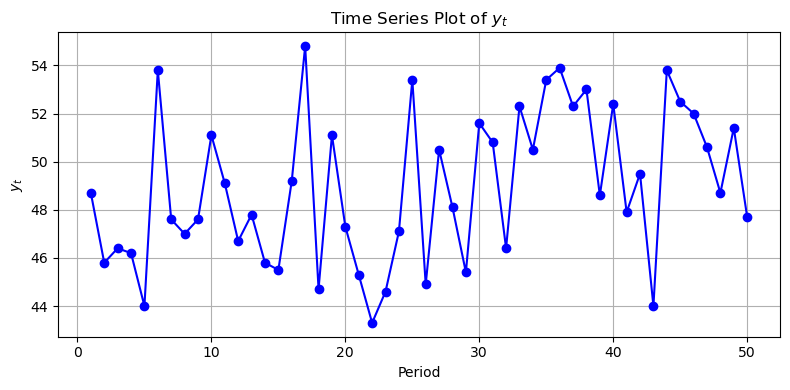

In [4]:
# Plot the time series
plt.figure(figsize=(8, 4))
plt.plot(df_y.index, df_y['y_t'], marker='o', linestyle='-', color='blue')  # Line + points
plt.title('Time Series Plot of $y_t$', fontsize=12)
plt.xlabel('Period', fontsize=10)
plt.ylabel('$y_t$', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

**b. Use simple exponential smoothing with 𝜆 = 0.2 to smooth the
first 40 time periods of this data. How well does this smoothing
procedure work?**

**Smoothing Equation**
$$
\hat{y}_t = \lambda y_{t-1} + (1 - \lambda) \hat{y}_{t-1}
$$
Where:
- $ \hat{y}_t $: Forecasted value at time $ t $
- $ y_{t-1} $: Actual observed value at time $ t - 1 $
- $ \hat{y}_{t-1} $: Forecasted value at time $ t - 1 $
- $ \lambda $: Smoothing parameter, $ 0 < \lambda < 1 $

**Interpretation of $ \lambda $**

| Value of $ \lambda $ | Interpretation                                   |
|----------------------|--------------------------------------------------|
| Close to 0           | Forecast reacts slowly to changes (more smoothing) |
| Close to 1           | Forecast reacts quickly to changes (less smoothing) |

**For $ \lambda = 0.2 $**

- 20% weight is given to the most recent actual observation.
- 80% weight is given to the previous forecast.
- The result is a **smoother** curve that is **less responsive** to recent fluctuations.

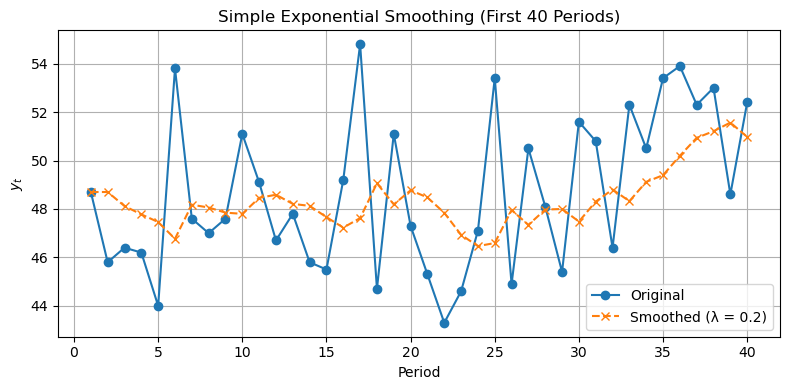

In [5]:
# Split into train (1-40) and test (41-50)
train = df_y.iloc[:40]
test = df_y.iloc[40:]

# Apply Simple Exponential Smoothing with λ = 0.2
model_ses = SimpleExpSmoothing(train, initialization_method="legacy-heuristic").fit(smoothing_level=0.2, optimized=False)

# Get smoothed values
y_smooth = model_ses.fittedvalues

# Plot original and smoothed series
plt.figure(figsize=(8, 4))
plt.plot(train.index, train, label='Original', marker='o')
plt.plot(y_smooth.index, y_smooth, label='Smoothed (λ = 0.2)', linestyle='--', marker='x')
plt.title('Simple Exponential Smoothing (First 40 Periods)')
plt.xlabel('Period')
plt.ylabel('$y_t$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show();

**c. Make one-step-ahead forecasts of the last 10 observations. Determine the forecast errors.**

In [6]:
# Transform series to pandas DataFrame (smoothed)
df_smoothed = pd.DataFrame(y_smooth, columns=['y_smooth'])

# One-step-ahead forecasts for last 10 periods
forecasts = []
last_smoothed = df_smoothed['y_smooth'].iloc[-1]                           # Last smoothed value from training

for t in range(len(test)):
    forecasts.append(last_smoothed)                                        # Forecast is the previous smoothed value
    last_smoothed = 0.2 * test['y_t'].iloc[t] + (1 - 0.2) * last_smoothed  # Update smoothed value with actual observation

# Create DataFrame with forecasts and errors
df_forecast = pd.DataFrame({
    'y_t': test['y_t'],
    'Forecast': forecasts
}, index=test.index)
df_forecast['Error'] = df_forecast['y_t'] - df_forecast['Forecast']

# Display results
df_forecast

,y_t,Forecast,Error
Period,,,
41,47.9,50.973838,-3.073838
42,49.5,50.359071,-0.859071
43,44.0,50.187257,-6.187257
44,53.8,48.949805,4.850195
45,52.5,49.919844,2.580156
46,52.0,50.435875,1.564125
47,50.6,50.748700,-0.148700
48,48.7,50.718960,-2.018960
49,51.4,50.315168,1.084832


**d. Use simple exponential smoothing with the optimum value of 𝜆
to smooth the first 40 time periods of this data. How well does this smoothing
procedure work? Compare the results with those obtained before.**

In [7]:
# Function to calculate SSE for a given lambda
def sse_lambda(lambda_val, series):
    smoothed = np.zeros(len(series))  # Initialize as numpy array
    smoothed[0] = series.iloc[0]      # Set first value
    for t in range(1, len(series)):
        smoothed[t] = lambda_val * series.iloc[t] + (1 - lambda_val) * smoothed[t-1]
    errors = series - smoothed        # Subtract numpy array from series
    return np.sum(errors**2)

# Optimize lambda (minimize SSE)
result = minimize(sse_lambda, x0=0.2, args=(train['y_t'],), bounds=[(0, 1)])
optimal_lambda = result.x[0]

# Smooth with optimal lambda
smoothed_opt = [train['y_t'].iloc[0]]  # Initialize with first value
for t in range(1, len(train)):
    smoothed_opt.append(optimal_lambda * train['y_t'].iloc[t] + (1 - optimal_lambda) * smoothed_opt[t-1])

# Smooth with lambda = 0.2 for comparison
lambda_02 = 0.2
smoothed_02 = [train['y_t'].iloc[0]]  # Initialize with first value
for t in range(1, len(train)):
    smoothed_02.append(lambda_02 * train['y_t'].iloc[t] + (1 - lambda_02) * smoothed_02[t-1])

# Create DataFrame with both smoothings
df_compare = pd.DataFrame({
    'y_t': train['y_t'],
    'Smoothed_0.2': smoothed_02,
    'Smoothed_Optimal': smoothed_opt
}, index=train.index)

# Calculate MSE for both
mse_02 = ((df_compare['y_t'] - df_compare['Smoothed_0.2']) ** 2).mean()
mse_opt = ((df_compare['y_t'] - df_compare['Smoothed_Optimal']) ** 2).mean()

# Display results
print(f"Optimal Lambda: {optimal_lambda:.4f}")
print(f"MSE (λ = 0.2): {mse_02:.2f}")
print(f"MSE (λ = {optimal_lambda:.4f}): {mse_opt:.2f}")
print()
print(df_compare.head())

Optimal Lambda: 1.0000
MSE (λ = 0.2): 6.21
MSE (λ = 1.0000): 0.00

         y_t  Smoothed_0.2  Smoothed_Optimal
Period                                      
1       48.7      48.70000              48.7
2       45.8      48.12000              45.8
3       46.4      47.77600              46.4
4       46.2      47.46080              46.2
5       44.0      46.76864              44.0


The optimization yields an optimal $\lambda = 1.0000$, with $MSE = 0.00$, meaning the smoothed series equals the original data ($S_t = y_t$), indicating no smoothing. For $\lambda = 0.2$, $MSE = 6.21$, showing some smoothing but with error (average deviation $\approx 2.49$). Data comparison:

| Period | $y_t$ | Smoothed ($\lambda = 0.2$) | Smoothed ($\lambda = 1$) |
|--------|-------|----------------------------|--------------------------|
| 1      | 48.7  | 48.70                      | 48.7                     |
| 2      | 45.8  | 48.12                      | 45.8                     |
| 3      | 46.4  | 47.78                      | 46.4                     |

$\lambda = 1$ fits perfectly but doesn't smooth, while $\lambda = 0.2$ smooths but lags, suggesting high variability in the data.

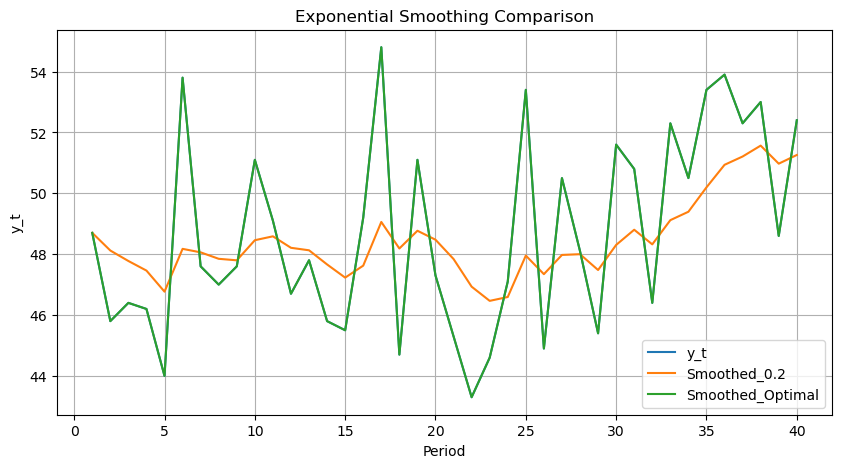

In [8]:
df_compare.plot(figsize=(10, 5), title='Exponential Smoothing Comparison')
plt.ylabel('y_t')
plt.grid(True)
plt.show()

**Another way**

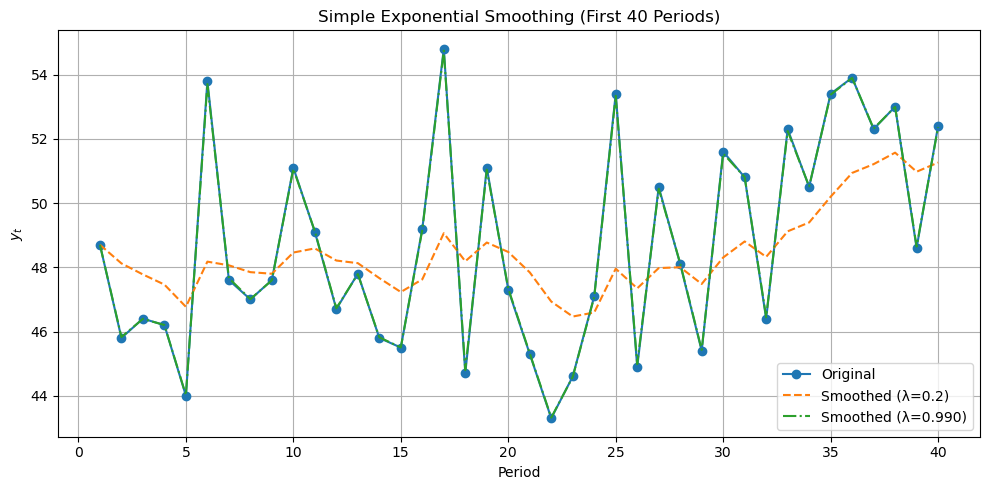

Optimal λ: 0.9900
MSE (λ = 0.2): 6.2125
MSE (λ = 0.9900): 0.0017



,y_t,Smoothed_λ=0.2,Smoothed_λ=0.990
1,48.7,48.70000,48.700000
2,45.8,48.12000,45.829000
3,46.4,47.77600,46.394290
4,46.2,47.46080,46.201943
5,44.0,46.76864,44.022019


In [9]:
# Step 1: Define the first 40 time periods
train = df_y.iloc[:40]                # Use first 40 periods
y_true = train['y_t']                 # Actual values

# Step 2: Define SSE function for a given λ
def sse_lambda(lambda_val, series):
    s = np.zeros(len(series))        # Initialize smoothed values
    s[0] = series.iloc[0]            # First smoothed value equals first observation
    for t in range(1, len(series)):
        s[t] = lambda_val * series.iloc[t] + (1 - lambda_val) * s[t-1]
    return np.sum((series.values - s) ** 2)  # Sum of squared errors

# Step 3: Minimize SSE to find optimal λ
result = minimize(sse_lambda,
                  x0=[0.5],                          # Initial guess
                  args=(y_true,),
                  bounds=[(0.01, 0.99)])             # Avoid edge case λ=1
optimal_lambda = result.x[0]

# Step 4: Apply SES with optimal λ
smoothed_opt = [y_true.iloc[0]]
for t in range(1, len(y_true)):
    smoothed_opt.append(optimal_lambda * y_true.iloc[t] + (1 - optimal_lambda) * smoothed_opt[t-1])

# Step 5: Apply SES with λ = 0.2
lambda_02 = 0.2
smoothed_02 = [y_true.iloc[0]]
for t in range(1, len(y_true)):
    smoothed_02.append(lambda_02 * y_true.iloc[t] + (1 - lambda_02) * smoothed_02[t-1])

# Step 6: Create a DataFrame for comparison
df_compare = pd.DataFrame({
    'y_t': y_true.values,
    'Smoothed_λ=0.2': smoothed_02,
    f'Smoothed_λ={optimal_lambda:.3f}': smoothed_opt
}, index=range(1, 41))

# Step 7: Calculate MSEs
mse_02 = np.mean((df_compare['y_t'] - df_compare['Smoothed_λ=0.2'])**2)
mse_opt = np.mean((df_compare['y_t'] - df_compare[f'Smoothed_λ={optimal_lambda:.3f}'])**2)

# Step 8: Plot the result
plt.figure(figsize=(10, 5))
plt.plot(df_compare['y_t'], label='Original', marker='o')
plt.plot(df_compare['Smoothed_λ=0.2'], label='Smoothed (λ=0.2)', linestyle='--')
plt.plot(df_compare[f'Smoothed_λ={optimal_lambda:.3f}'], label=f'Smoothed (λ={optimal_lambda:.3f})', linestyle='-.')

plt.title('Simple Exponential Smoothing (First 40 Periods)')
plt.xlabel('Period')
plt.ylabel('$y_t$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 9: Print comparison
print(f"Optimal λ: {optimal_lambda:.4f}")
print(f"MSE (λ = 0.2): {mse_02:.4f}")
print(f"MSE (λ = {optimal_lambda:.4f}): {mse_opt:.4f}")
print()
df_compare.head()

**e. Make one-step-ahead forecasts of the last 10 observations. Determine the forecast errors. Compare these forecast errors with those
from Exercise 4.1. How much has using the optimum value of
the smoothing constant improved the forecasts?**

In [10]:
# Step 1: Split into training (first 40) and test (last 10)
train = df_y.iloc[:40].copy()
test = df_y.iloc[40:].copy()

# Step 2: Define SSE function to optimize lambda
def sse_lambda(lambda_val, series):
    s = np.zeros(len(series))
    s[0] = series.iloc[0]
    for t in range(1, len(series)):
        s[t] = lambda_val * series.iloc[t] + (1 - lambda_val) * s[t-1]
    return np.sum((series.values - s)**2)

# Step 3: Find optimal lambda
result = minimize(sse_lambda, x0=[0.5], args=(train['y_t'],), bounds=[(0.01, 0.99)])
lambda_opt = result.x[0]

# Step 4: Fit model with lambda = 0.2
lambda_02 = 0.2
s_02 = [train['y_t'].iloc[0]]
for t in range(1, len(train)):
    s_02.append(lambda_02 * train['y_t'].iloc[t] + (1 - lambda_02) * s_02[t-1])

# Step 5: Forecast next 10 values using λ = 0.2
forecasts_02 = []
last_s_02 = s_02[-1]
for _ in range(10):
    forecasts_02.append(last_s_02)  # One-step ahead forecast is last smoothed value
    last_s_02 = lambda_02 * test['y_t'].iloc[_] + (1 - lambda_02) * last_s_02  # update

# Step 6: Fit model with optimal lambda
s_opt = [train['y_t'].iloc[0]]
for t in range(1, len(train)):
    s_opt.append(lambda_opt * train['y_t'].iloc[t] + (1 - lambda_opt) * s_opt[t-1])

# Step 7: Forecast next 10 values using optimal λ
forecasts_opt = []
last_s_opt = s_opt[-1]
for _ in range(10):
    forecasts_opt.append(last_s_opt)
    last_s_opt = lambda_opt * test['y_t'].iloc[_] + (1 - lambda_opt) * last_s_opt

# Step 8: Create results DataFrame
results = pd.DataFrame({
    'Actual': test['y_t'].values,
    'Forecast_0.2': forecasts_02,
    'Error_0.2': test['y_t'].values - np.array(forecasts_02),
    f'Forecast_λ={lambda_opt:.3f}': forecasts_opt,
    f'Error_λ={lambda_opt:.3f}': test['y_t'].values - np.array(forecasts_opt)
}, index=test.index)

# Step 9: Calculate MSEs
mse_02 = np.mean(results['Error_0.2']**2)
mse_opt = np.mean(results[f'Error_λ={lambda_opt:.3f}']**2)

# Step 10: Print results
print(results.round(2))
print()
print(f"Mean Squared Error (λ = 0.2): {mse_02:.3f}")
print(f"Mean Squared Error (λ = {lambda_opt:.3f}): {mse_opt:.3f}")

        Actual  Forecast_0.2  Error_0.2  Forecast_λ=0.990  Error_λ=0.990
Period                                                                  
41        47.9         51.26      -3.36             52.36          -4.46
42        49.5         50.59      -1.09             47.94           1.56
43        44.0         50.37      -6.37             49.48          -5.48
44        53.8         49.10       4.70             44.05           9.75
45        52.5         50.04       2.46             53.70          -1.20
46        52.0         50.53       1.47             52.51          -0.51
47        50.6         50.82      -0.22             52.01          -1.41
48        48.7         50.78      -2.08             50.61          -1.91
49        51.4         50.36       1.04             48.72           2.68
50        47.7         50.57      -2.87             51.37          -3.67

Mean Squared Error (λ = 0.2): 9.709
Mean Squared Error (λ = 0.990): 17.541


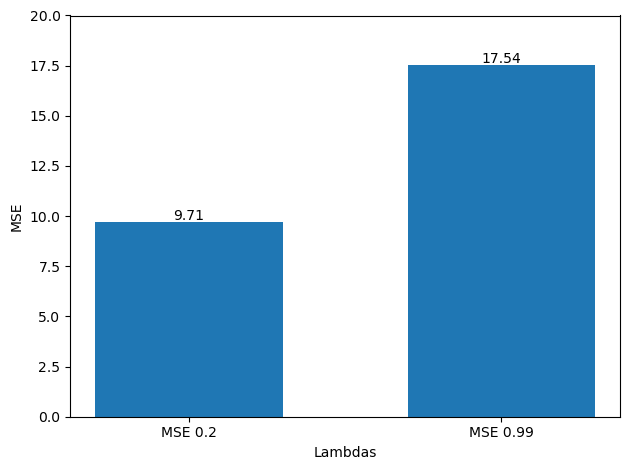

In [11]:
fig, ax = plt.subplots()

x = ['MSE 0.2', 'MSE 0.99']
y = [mse_02, mse_opt]

ax.bar(x, y, width=0.6)
ax.set_xlabel('Lambdas')
ax.set_ylabel('MSE')
ax.set_ylim(0, 20)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()
plt.show();

    Despite optimizing λ to minimize SSE (in-sample) over the first 40 observations, it does not guarantee better forecast performance on the out-of-sample (test) set — and that's exactly what happened here: Overfitting.

**f. Find the sample ACF for the time series in Table E4.1. Does this give
you any insight about the optimum value of the smoothing constant
that you found before?**

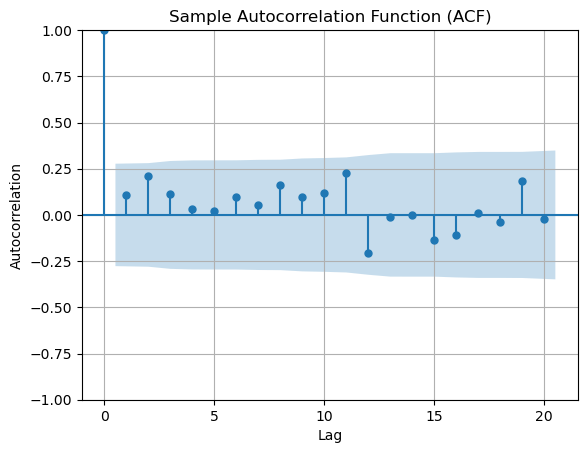

In [12]:
plot_acf(df_y['y_t'], lags=20, alpha=0.05)
plt.title('Sample Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

In [13]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df_y['y_t'])

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -3.700190721542112
p-value: 0.0041104722693405165

p-value < alpha; Ha: Stationary


A lower $\lambda$ (e.g., 0.2) smooths fluctuations better and improves forecast stability.

**4.7 Consider the time series data shown in Table E4.3.**

In [14]:
# Re-enter the data after code execution state reset
data = {
    "Period": list(range(1, 51)),
    "y_t": [
        275, 245, 222, 169, 236, 259, 268, 225, 246, 263,
        297, 235, 237, 203, 238, 232, 206, 295, 247, 227,
        231, 238, 251, 253, 283, 283, 245, 234, 273, 293,
        255, 255, 229, 286, 236, 194, 228, 244, 241, 284,
        293, 284, 276, 290, 250, 235, 275, 350, 290, 269
    ]
}
# Create the DataFrame
df_e47 = pd.DataFrame(data)
df_e47.head()

,Period,y_t
0,1,275
1,2,245
2,3,222
3,4,169
4,5,236


**a. Make a time series plot of the data.**

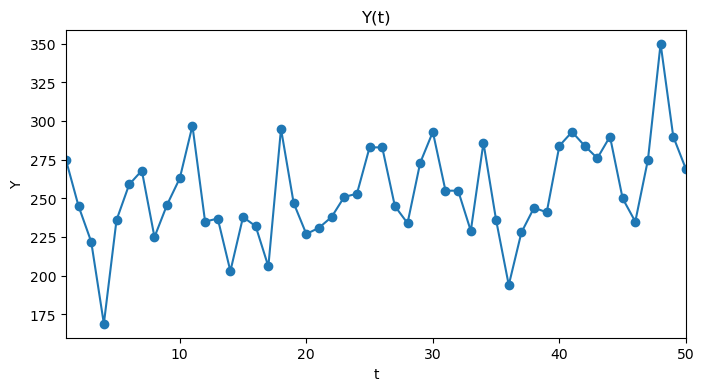

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df_e47['Period'],df_e47['y_t'], marker='o')   # markerfacecolor='red'
ax.set_xlabel('t')
ax.set_ylabel('Y')
ax.set_xlim(1,50)
plt.title('Y(t)')
plt.show();

**b. Use simple exponential smoothing with 𝜆 = 0.1 to smooth the
first 30 time periods of this data. How well does this smoothing
procedure work?**

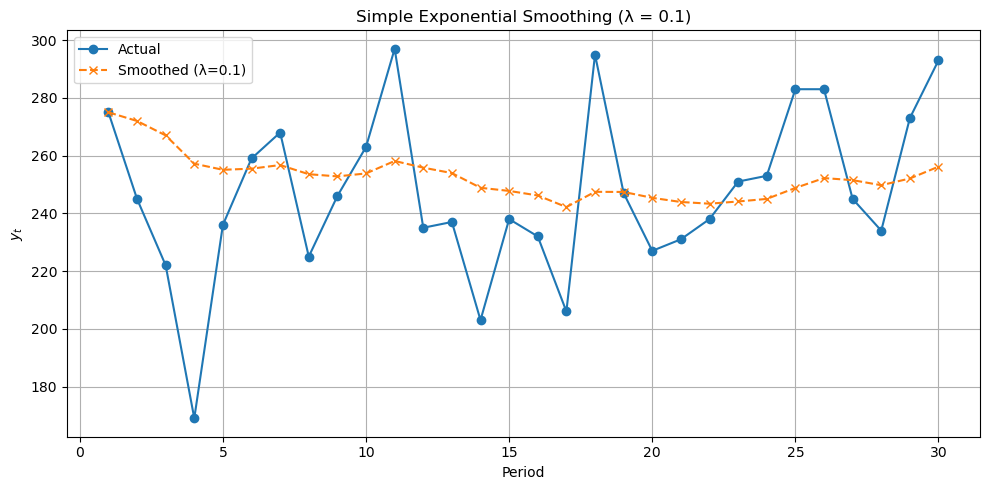

Mean Squared Error (λ = 0.1): 834.30


In [16]:
# Step 1: Define the time series (first 30 periods only)
yt_30 = df_e47['y_t'].iloc[:30]        # Extract first 30 periods
lambda_ = 0.1                          # Smoothing constant

# Step 2: Initialize smoothed series
S = [yt_30.iloc[0]]                    # First smoothed value S_1 = y_1

# Step 3: Apply simple exponential smoothing
for t in range(1, len(yt_30)):
    S.append(lambda_ * yt_30.iloc[t] + (1 - lambda_) * S[-1])

# Step 4: Create DataFrame to compare actual vs smoothed
df_smooth = pd.DataFrame({
    'Period': yt_30.index + 1,
    'Actual': yt_30.values,
    'Smoothed (λ=0.1)': S
}).set_index('Period')

# Step 5: Plot actual vs smoothed values
plt.figure(figsize=(10, 5))
plt.plot(df_smooth['Actual'], label='Actual', marker='o')
plt.plot(df_smooth['Smoothed (λ=0.1)'], label='Smoothed (λ=0.1)', linestyle='--', marker='x')
plt.title('Simple Exponential Smoothing (λ = 0.1)')
plt.xlabel('Period')
plt.ylabel('$y_t$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Step 6: Evaluate smoothing performance
mse = np.mean((df_smooth['Actual'] - df_smooth['Smoothed (λ=0.1)']) ** 2)
print(f'Mean Squared Error (λ = 0.1): {mse:.2f}')

**c. Make one-step-ahead forecasts of the last 20 observations. Determine the forecast errors.**

In [17]:
# Step 1: Define parameters and series
lambda_ = 0.1
yt_full = df_e47['y_t']                      # Full series
train = yt_full.iloc[:30]                    # First 30 for smoothing
test = yt_full.iloc[30:50]                   # Last 20 for forecasting

# Step 2: Initialize smoothed series with first observation
S = [train.iloc[0]]

# Step 3: Compute smoothed values for training period
for t in range(1, len(train)):
    S.append(lambda_ * train.iloc[t] + (1 - lambda_) * S[-1])

# Step 4: Forecast using last smoothed value
forecast_0_1 = []
last_smoothed = S[-1]
for i in range(len(test)):
    forecast_0_1.append(last_smoothed)
    last_smoothed = lambda_ * test.iloc[i] + (1 - lambda_) * last_smoothed  # update smoothed value

# Step 5: Create result DataFrame
df_forecast = pd.DataFrame({
    'Actual': test.values,
    'Forecast (λ=0.1)': forecast_0_1
}, index=test.index)

# Step 6: Compute forecast errors
df_forecast['Error'] = df_forecast['Actual'] - df_forecast['Forecast (λ=0.1)']
df_forecast['Squared Error'] = df_forecast['Error'] ** 2
mse = df_forecast['Squared Error'].mean()

# Show result
print(f"Mean Squared Error (λ = 0.1): {mse:.2f}")
print()
display(df_forecast)

Mean Squared Error (λ = 0.1): 1081.13



,Actual,Forecast (λ=0.1),Error,Squared Error
30,255,256.161546,-1.161546,1.349189
31,255,256.045391,-1.045391,1.092843
32,229,255.940852,-26.940852,725.809514
33,286,253.246767,32.753233,1072.774277
34,236,256.522090,-20.522090,421.156187
35,194,254.469881,-60.469881,3656.606533
36,228,248.422893,-20.422893,417.094562
37,244,246.380604,-2.380604,5.667274
38,241,246.142543,-5.142543,26.445753
39,284,245.628289,38.371711,1472.388201


**d. Plot the forecast errors on a control chart for individuals. Use
a moving range chart to estimate the standard deviation of the
forecast errors in constructing this chart. What conclusions can
you draw about the forecasting procedure and the time series?**

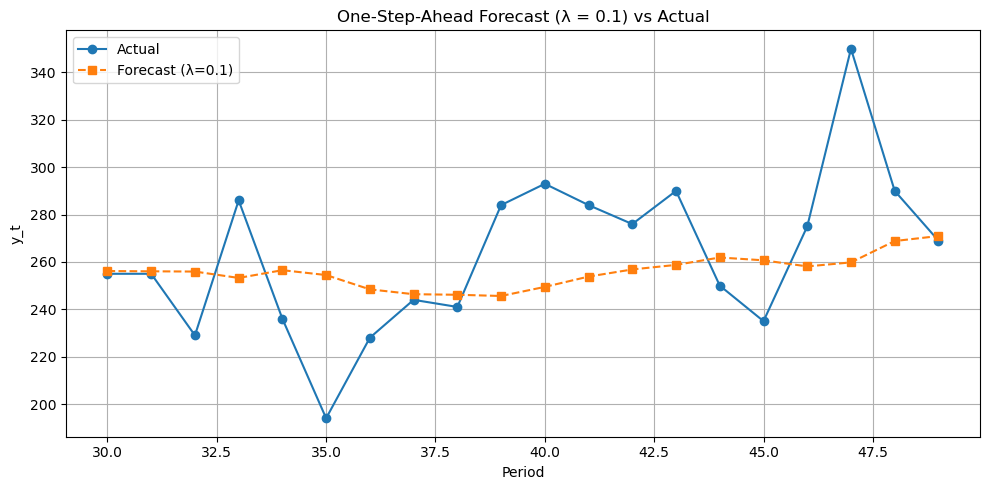

In [18]:
# Plot actual vs forecast values
plt.figure(figsize=(10, 5))
plt.plot(df_forecast.index, df_forecast['Actual'], marker='o', label='Actual')
plt.plot(df_forecast.index, df_forecast['Forecast (λ=0.1)'], marker='s', linestyle='--', label='Forecast (λ=0.1)')

# Add plot details
plt.title('One-Step-Ahead Forecast (λ = 0.1) vs Actual')
plt.xlabel('Period')
plt.ylabel('y_t')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

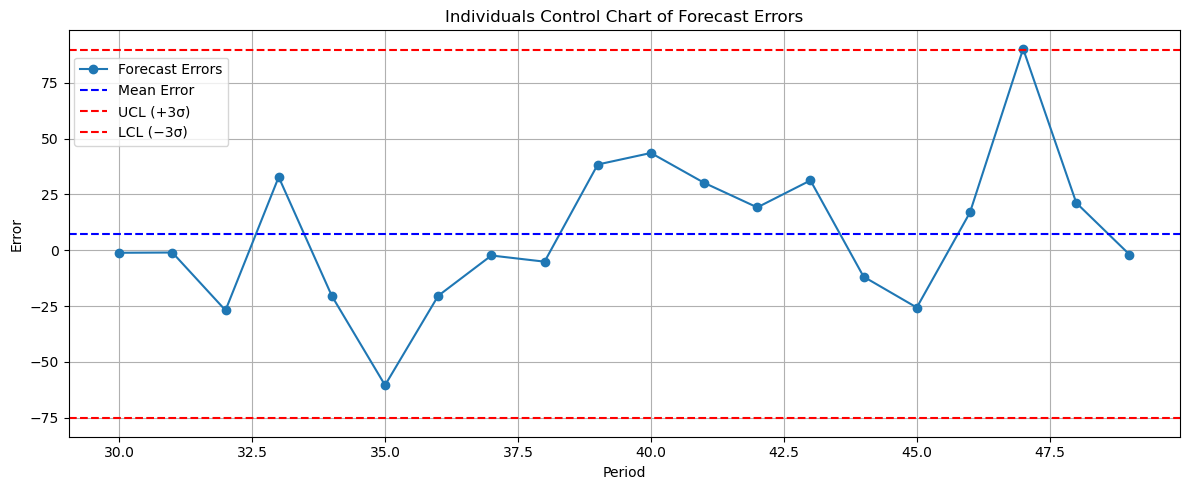

In [19]:
# Step 1: Get forecast errors
errors = df_forecast['Error']

# Step 2: Compute moving ranges (MR_t = |e_t - e_{t-1}|)
moving_ranges = np.abs(errors.diff().dropna())

# Step 3: Estimate sigma (std deviation) from moving ranges
MR_bar = moving_ranges.mean()
d2 = 1.128  # constant for MR of 2 samples
sigma = MR_bar / d2

# Step 4: Control chart limits for Individuals chart
error_mean = errors.mean()
UCL = error_mean + 3 * sigma
LCL = error_mean - 3 * sigma

# Step 5: Plot the Individuals Control Chart
plt.figure(figsize=(12, 5))
plt.plot(errors.index, errors, marker='o', label='Forecast Errors')
plt.axhline(error_mean, color='blue', linestyle='--', label='Mean Error')
plt.axhline(UCL, color='red', linestyle='--', label='UCL (+3σ)')
plt.axhline(LCL, color='red', linestyle='--', label='LCL (−3σ)')

plt.title('Individuals Control Chart of Forecast Errors')
plt.xlabel('Period')
plt.ylabel('Error')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(0.15, 0.95))
plt.tight_layout()
plt.show()

**4.11 Reconsider the US Treasury Securities data shown in Table B.1.**

In [20]:
usts = pd.read_csv('data/Sorted_Treasury_Rates.csv')
usts['Date'] = pd.to_datetime(usts['Month'])     # Ensure it's in datetime format
usts = usts.set_index('Date')                    # Set as index
usts = usts.sort_index()                         # Sort the index chronologically
usts.drop(columns='Month', inplace=True)         # Drop 'Month' column if still present
usts = usts.rename(columns={'Rate (%)': 'Rate'}) # Rename column

usts.head()

,Rate
Date,
1953-04-01,2.83
1953-05-01,3.05
1953-06-01,3.11
1953-07-01,2.93
1953-08-01,2.95


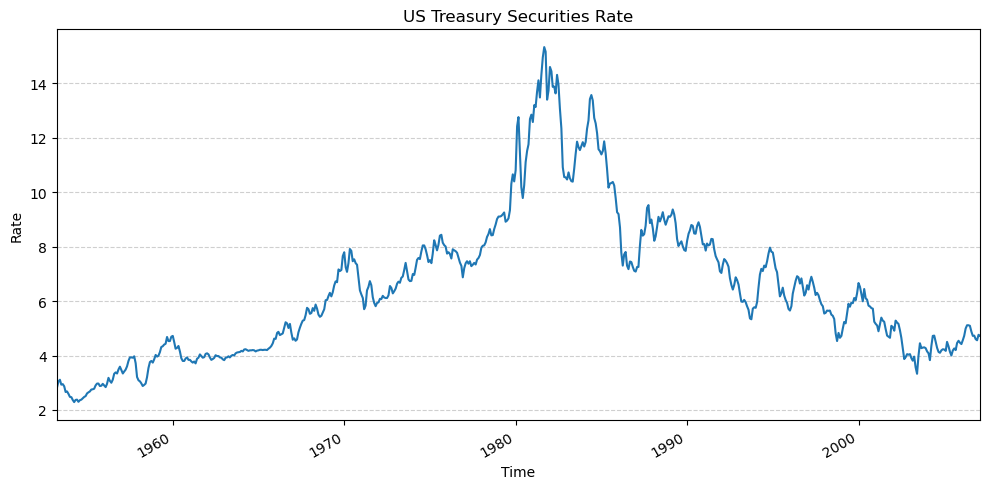

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(usts)
ax.set_xlabel('Time')
ax.set_ylabel('Rate')
ax.set_title('US Treasury Securities Rate')
ax.set_xlim(pd.to_datetime('1953-04-01'), pd.to_datetime('2007-02-01'))
ax.grid(axis='y', linestyle='--', alpha=0.6)  

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

**a. Use simple exponential smoothing with the optimum value of 𝜆 to
smooth the data, excluding the last 20 observations. How well does this smoothing
procedure work?**

✅ Optimal λ: 0.9900
📉 Mean Squared Error: 0.0000

            Original  Smoothed (λ=0.990)
Date                                    
1953-04-01      2.83            2.830000
1953-05-01      3.05            3.047800
1953-06-01      3.11            3.109378
1953-07-01      2.93            2.931794
1953-08-01      2.95            2.949818


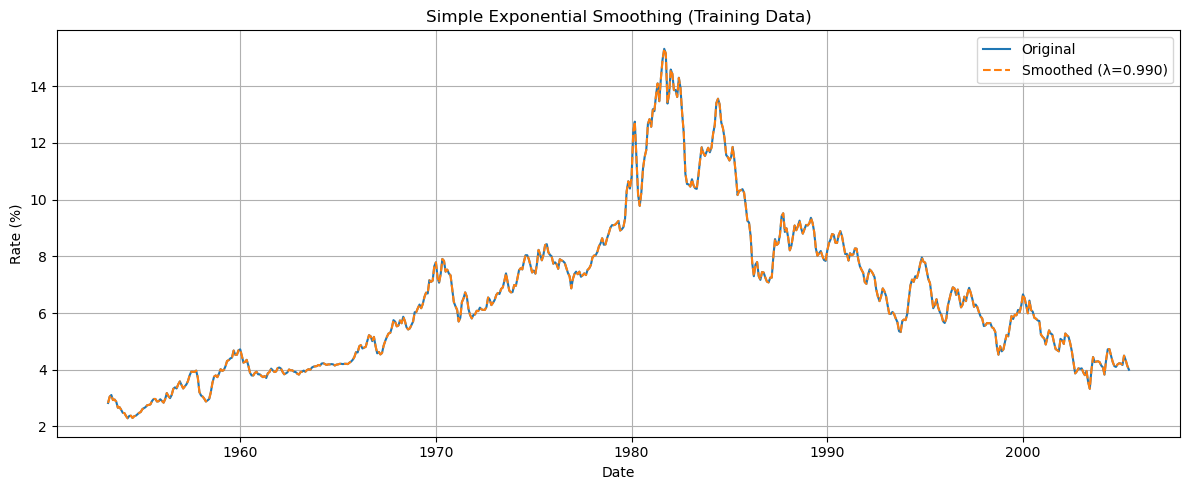

In [22]:
# Step 1: Split into training (exclude last 20 obs)
train = usts.iloc[:-20]['Rate']               # First part for training

# Step 2: Define SSE function to minimize
def sse_lambda(lambda_val, series):
    smoothed = np.zeros(len(series))
    smoothed[0] = series.iloc[0]
    for t in range(1, len(series)):
        smoothed[t] = lambda_val * series.iloc[t] + (1 - lambda_val) * smoothed[t-1]
    errors = series.values - smoothed
    return np.sum(errors**2)

# Step 2: Optimize lambda
result = minimize(sse_lambda, x0=0.3, args=(train,), bounds=[(0.01, 0.99)])
optimal_lambda = result.x[0]

# Step 4: Apply smoothing with optimal lambda
smoothed = [train.iloc[0]]
for t in range(1, len(train)):
    smoothed.append(optimal_lambda * train.iloc[t] + (1 - optimal_lambda) * smoothed[t-1])

# Step 5: Create result DataFrame
df_result = pd.DataFrame({
    'Original': train.values,
    f'Smoothed (λ={optimal_lambda:.3f})': smoothed
}, index=train.index)

# Step 7: Calculate MSE
mse = np.mean((df_result['Original'] - df_result.iloc[:, 1])**2)

# Step 8: Display result and plot
print(f"✅ Optimal λ: {optimal_lambda:.4f}")
print(f"📉 Mean Squared Error: {mse:.4f}\n")
print(df_result.head())

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_result.index, df_result['Original'], label='Original')
plt.plot(df_result.index, df_result.iloc[:, 1], label=f'Smoothed (λ={optimal_lambda:.3f})', linestyle='--')
plt.title('Simple Exponential Smoothing (Training Data)')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Optimal λ (with regularization): 0.9212
Mean Squared Error (forecasting): 0.0202


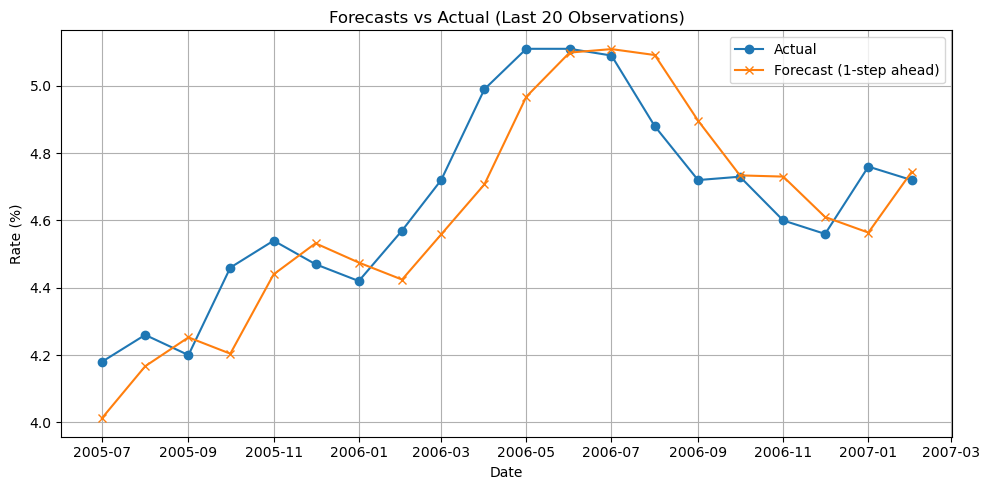

In [23]:
# Step 1: Prepare the data
train = usts.iloc[:-20].copy()      # Exclude last 20 points for test
test = usts.iloc[-20:].copy()       # Holdout set for forecast testing

# Step 2: Define penalized SSE function
def penalized_sse_lambda(lambda_val, series):
    smoothed = np.zeros(len(series))
    smoothed[0] = series.iloc[0]
    for t in range(1, len(series)):
        smoothed[t] = lambda_val * series.iloc[t] + (1 - lambda_val) * smoothed[t-1]
    errors = series.values - smoothed
    penalty = 10 * (lambda_val - 0.5)**2         # Regularization: penalize λ far from 0.5
    return np.sum(errors**2) + penalty

# Step 3: Optimize lambda with regularization
result = minimize(penalized_sse_lambda, x0=0.5, args=(train['Rate'],), bounds=[(0.01, 0.99)])
optimal_lambda = result.x[0]

# Step 4: Smooth the training series with optimal lambda
smoothed = [train['Rate'].iloc[0]]  # Initialize with first value
for t in range(1, len(train)):
    smoothed.append(optimal_lambda * train['Rate'].iloc[t] + (1 - optimal_lambda) * smoothed[t-1])

# Step 5: Forecast the last 20 points (one-step-ahead)
forecasts = []
last_smoothed = smoothed[-1]    # Start from final smoothed value of training
for t in range(20):
    forecasts.append(last_smoothed)     # Forecast is always last smoothed value
    last_smoothed = optimal_lambda * test['Rate'].iloc[t] + (1 - optimal_lambda) * last_smoothed

# Step 6: Evaluate forecast performance
forecast_errors = test['Rate'].values - forecasts
mse = np.mean(forecast_errors**2)

# Step 7: Display results
print(f"Optimal λ (with regularization): {optimal_lambda:.4f}")
print(f"Mean Squared Error (forecasting): {mse:.4f}")

# Step 8: Plot forecasts vs actual
plt.figure(figsize=(10, 5))
plt.plot(test.index, test.values, label='Actual', marker='o')
plt.plot(test.index, forecasts, label='Forecast (1-step ahead)', marker='x')
plt.title('Forecasts vs Actual (Last 20 Observations)')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show();

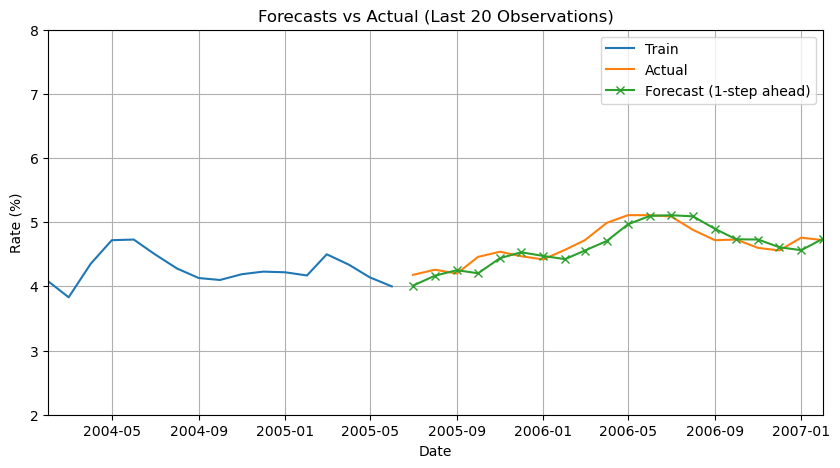

In [24]:
# Step 8: Plot forecasts vs actual
plt.figure(figsize=(10, 5))
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, forecasts, label='Forecast (1-step ahead)', marker='x')
plt.title('Forecasts vs Actual (Last 20 Observations)')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.xlim(pd.to_datetime('2004-02-01'), pd.to_datetime('2007-02-01'))
plt.ylim(2,8)
plt.grid(True)
plt.show();